# Exploratory Data Analysis (EDA) + some additional cleaning & feature engineering

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
import seaborn as sns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [2]:
pd.set_option('float_format', '{:f}'.format)  #so that floats will print w/o scientific notat.

In [3]:
os.getcwd();

In [4]:
df = pd.read_csv('/Users/ryanrappa/Desktop/dsi/film-profit-prediction/csv_files/clean_data_v1.csv')

In [5]:
df = df.drop("Unnamed: 0", axis=1) #drop superfluous index col

In [6]:
df['release_date'] = pd.to_datetime(df['release_date']) #convert release from obj to datetime

In [7]:
#how many movies were profitable?
df[df['made_money'] == 1].count();
#answer: 2525 out of 3600 were profitable, so the data is somewhat imbalanced

## Check for correlated variables (collinearity) & correlations with profit/made_money (predictors of profitability)

#### Some collinearity here: I'll address this with regularization when modeling, or by using just one of the correlated features from each "group" of correlated features

In [8]:
df.corr(method='pearson')

,budget,id,revenue,runtime,profit,made_money,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films
budget,1.000000,0.021716,0.731300,0.263423,0.590303,0.158025,0.543913,0.463589,0.455396,0.411952,0.414749,0.383094,0.361351,0.257271,0.264913,0.407651,0.381082,0.219286,0.235427,0.242557,0.238570,0.252493,0.245419,0.207863,0.193303,0.121572,0.109403,0.188341,0.177931,0.120212,0.108569
id,0.021716,1.000000,0.046456,-0.005516,0.049003,0.005173,0.189147,0.360020,0.343084,0.298994,0.305466,0.092020,0.075885,0.056282,0.057106,0.120337,0.105187,0.094960,0.099206,0.642578,0.644295,0.547787,0.570549,0.306197,0.265380,0.190537,0.185812,0.345802,0.319371,0.256636,0.259766
revenue,0.731300,0.046456,1.000000,0.266902,0.982232,0.329365,0.558621,0.376083,0.384813,0.284986,0.293223,0.321515,0.317120,0.169327,0.185726,0.397847,0.391345,0.182048,0.202175,0.179157,0.178843,0.174817,0.175932,0.157535,0.148552,0.099886,0.094802,0.151891,0.144747,0.109743,0.102111
runtime,0.263423,-0.005516,0.266902,1.000000,0.243384,0.068004,0.203253,0.153674,0.157535,0.144457,0.143888,0.229968,0.226488,0.225671,0.225829,0.186786,0.180347,0.161018,0.151663,-0.009611,-0.006824,-0.013124,-0.005868,0.007757,0.013590,0.008263,0.017948,0.014941,0.015390,0.018737,0.022241
profit,0.590303,0.049003,0.982232,0.243384,1.000000,0.346306,0.511441,0.317517,0.330103,0.223917,0.232894,0.275087,0.275869,0.129601,0.146905,0.358665,0.358281,0.155107,0.174486,0.145283,0.146009,0.137413,0.140678,0.129241,0.122616,0.084759,0.082092,0.127933,0.122342,0.096798,0.090970
made_money,0.158025,0.005173,0.329365,0.068004,0.346306,1.000000,0.283893,0.081669,0.088529,0.056393,0.076733,0.099941,0.101602,0.049589,0.074468,0.085950,0.083380,0.047834,0.065597,0.040958,0.044663,0.023026,0.031437,0.065811,0.068774,0.053280,0.069434,0.043601,0.042562,0.048483,0.053531
releases,0.543913,0.189147,0.558621,0.203253,0.511441,0.283893,1.000000,0.408233,0.398182,0.372514,0.369969,0.276401,0.262175,0.194808,0.196645,0.289857,0.271917,0.193845,0.195184,0.334663,0.325762,0.337961,0.334764,0.220868,0.198255,0.151098,0.141123,0.193701,0.174996,0.152225,0.142293
cast_rev,0.463589,0.360020,0.376083,0.153674,0.317517,0.081669,0.408233,1.000000,0.990495,0.878409,0.892028,0.256286,0.233301,0.211319,0.207889,0.320166,0.289298,0.231744,0.228262,0.493436,0.482913,0.474929,0.473436,0.283969,0.246273,0.177665,0.157847,0.284875,0.254767,0.204631,0.193840
cast_prof,0.455396,0.343084,0.384813,0.157535,0.330103,0.088529,0.398182,0.990495,1.000000,0.825005,0.847371,0.255904,0.236186,0.206176,0.203925,0.326199,0.300321,0.229065,0.225991,0.461416,0.451956,0.443831,0.443117,0.268683,0.233772,0.168086,0.150018,0.271674,0.243098,0.196270,0.186809
cast_films,0.411952,0.298994,0.284986,0.144457,0.223917,0.056393,0.372514,0.878409,0.825005,1.000000,0.983070,0.224247,0.196382,0.231319,0.223377,0.243636,0.207948,0.215041,0.207856,0.467772,0.457411,0.459200,0.453850,0.274831,0.239694,0.173254,0.152874,0.256309,0.227655,0.184857,0.172228


## Plot numerical cols (x-axes) against profits (y-axis, in $)

#### Looks like weak correlations in general, but not non-existent. Hopefully enough for a useful model later...

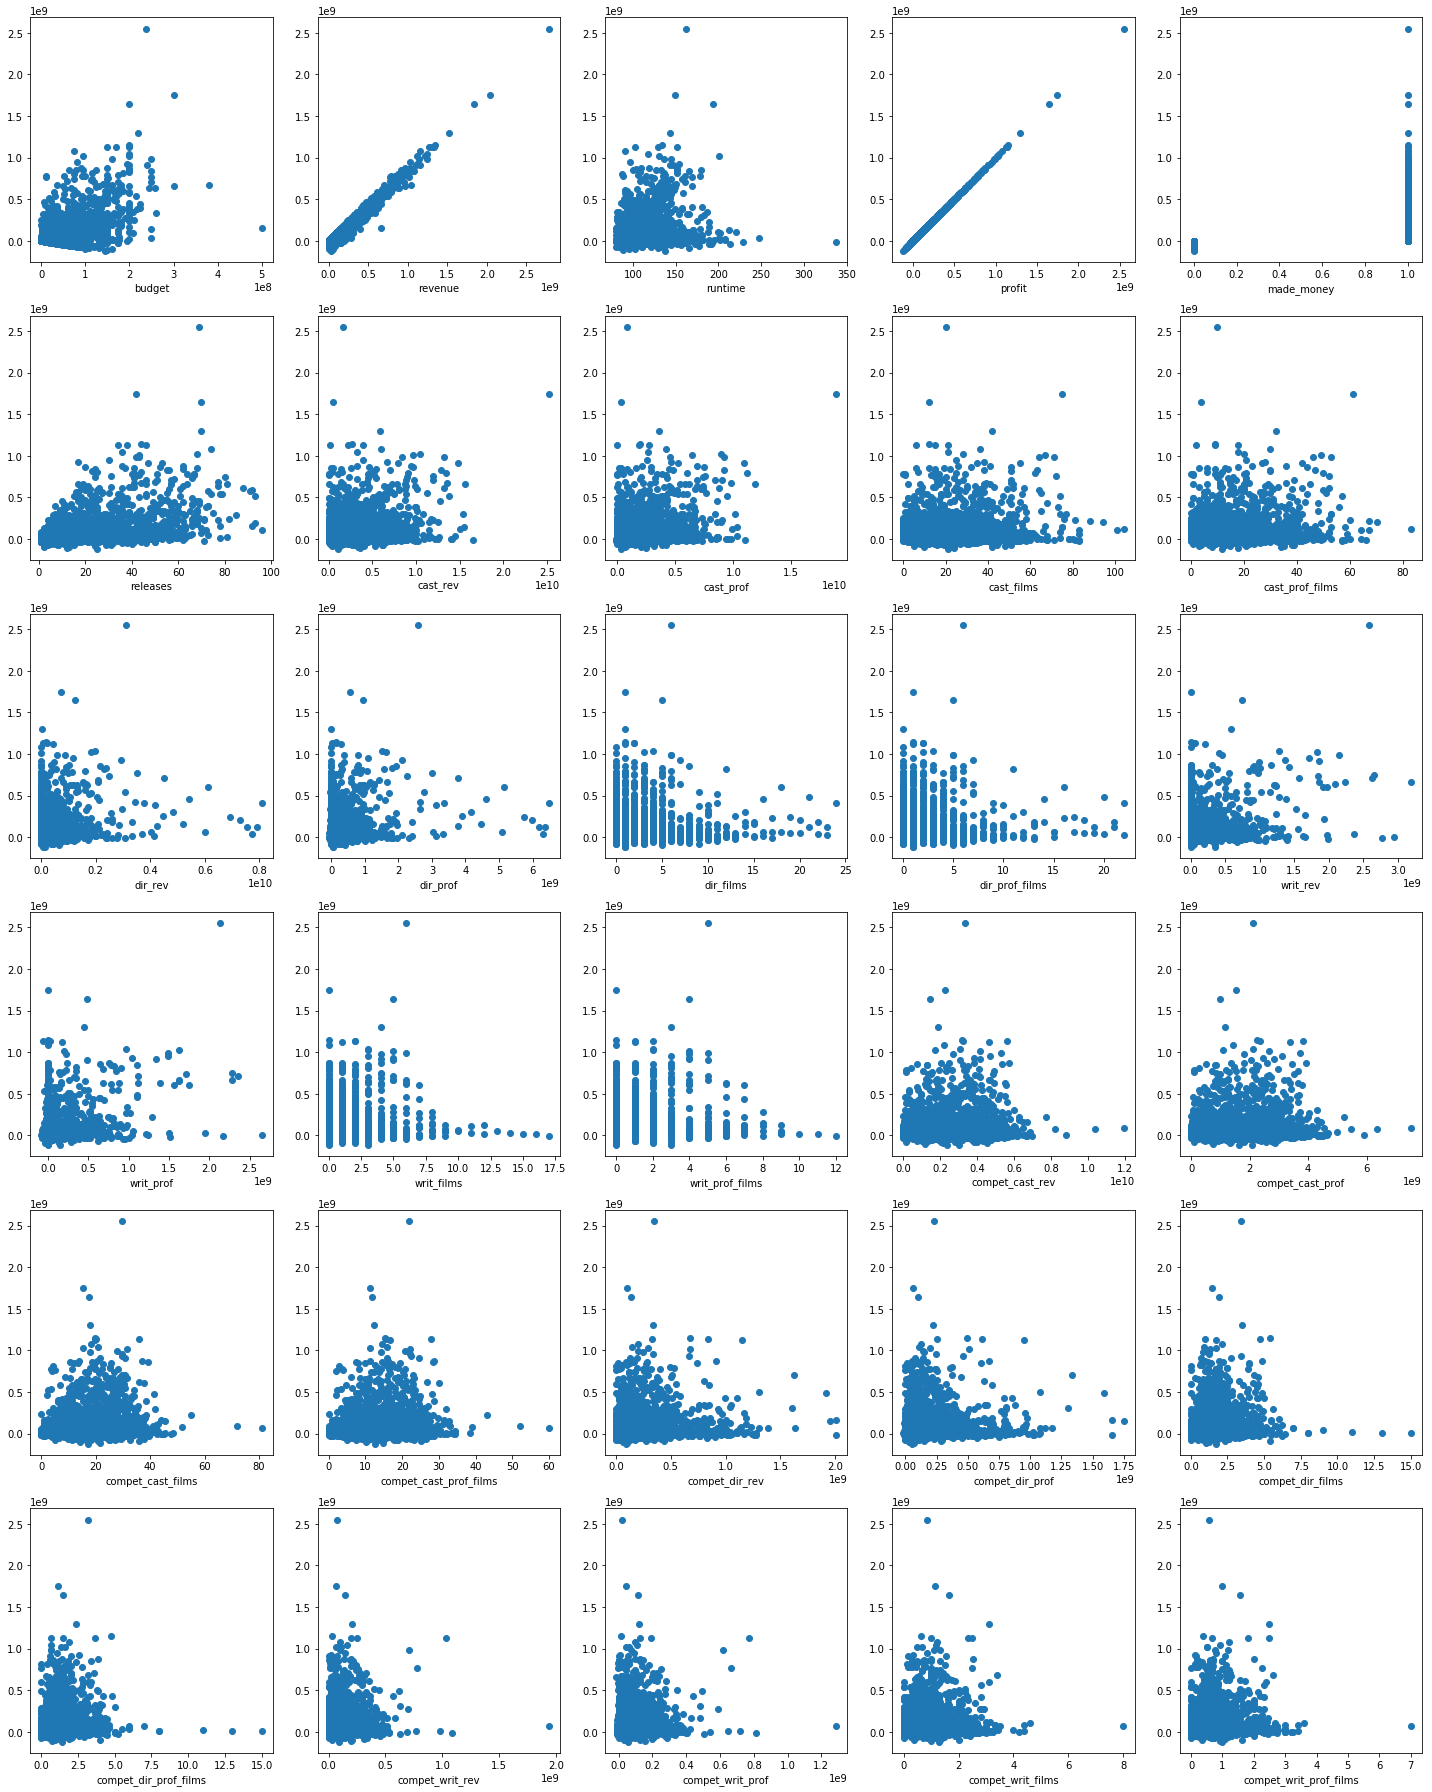

In [9]:
num_cols = ['budget', 'revenue', 'runtime', 'profit', 'made_money',
       'releases', 'cast_rev', 'cast_prof', 'cast_films', 'cast_prof_films', 'dir_rev', 'dir_prof',
       'dir_films', 'dir_prof_films', 'writ_rev', 'writ_prof', 'writ_films', 'writ_prof_films',
       'compet_cast_rev', 'compet_cast_prof', 'compet_cast_films', 'compet_cast_prof_films',
       'compet_dir_rev', 'compet_dir_prof', 'compet_dir_films', 'compet_dir_prof_films',
       'compet_writ_rev', 'compet_writ_prof', 'compet_writ_films', 'compet_writ_prof_films']

fig, axs = plt.subplots(6, 5, figsize=(20, 25))

for ax, col in zip(axs.flatten(), num_cols):
    ax.scatter(df[col], df['profit'])
    ax.set_xlabel(col)

plt.tight_layout() #can save the image below / zoom in for visibility

## Percentage of profitable movies by month

In [10]:
df['month'] = df['release_date'].dt.strftime('%m')

In [11]:
df_prof = df[df['made_money'] == 1]  #filtering for profitable films only

In [12]:
grouped = df_prof.groupby('month').count()

In [13]:
grouped['month'] = grouped.index
grouped_all = df.groupby('month').count()
grouped['count'] = grouped_all['id']
grouped['pct_prof'] = grouped['made_money'] / grouped['count']

#### Based on this plot & background research, it looks like there are -- roughly speaking -- four main seasons, for which I'll make dummy vars below: Jan-Apr (so-so movies), May-Jul (summer blockbusters), Aug-Oct (more so-so), and Nov-Dec (major Thanksgiving/Xmas movies)

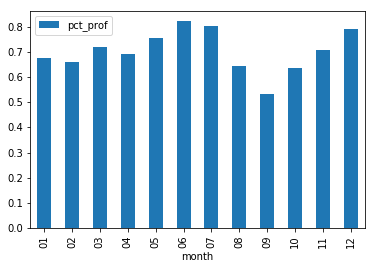

In [14]:
grouped.plot.bar(x='month', y='pct_prof')
plt.show()

## Percentage of profitable movies by genre

In [15]:
grouped2 = df_prof.groupby('genre').count()

In [16]:
grouped2['genre'] = grouped2.index
grouped_all2 = df.groupby('genre').count()
grouped2['count'] = grouped_all2['id']
grouped2['pct_prof'] = grouped2['made_money'] / grouped2['count']

#### Since it appears genre matters to profitability, will make dummy vars for genre

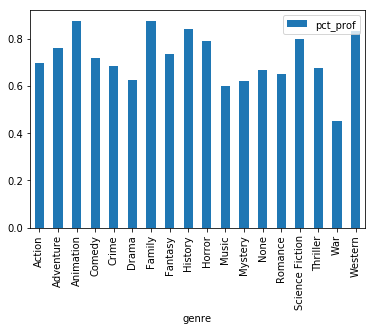

In [17]:
grouped2.plot.bar(x='genre', y='pct_prof')
plt.show()

## What decades are represented in the data?

In [18]:
df['year'] = df['release_date'].dt.strftime('%Y')

In [19]:
df = df.astype({"month": int, "year": int})

In [20]:
df['decade'] = (df['year']//10)*10

In [21]:
grouped3 = df.groupby('decade').count()

In [22]:
grouped3['decade'] = grouped3.index

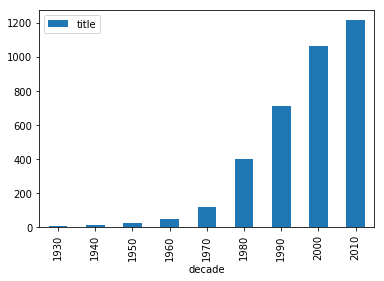

In [23]:
grouped3.plot.bar(x='decade', y='title')
plt.show()

In [24]:
df = df.astype({"decade": int})

## Relationship btw director/writer success and profitability

In [25]:
x = df['writ_prof'].values
y = df['dir_prof'].values
z = df['profit'].values

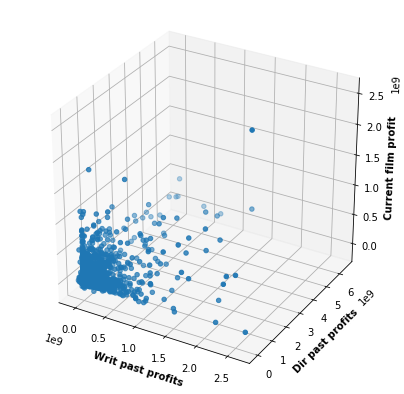

In [26]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x, ys=y, zs=z)
ax.set_xlabel('Writ past profits', fontweight='bold')
ax.set_ylabel('Dir past profits', fontweight='bold')
ax.set_zlabel('Current film profit', fontweight='bold')

plt.show()

#### trying to make best-fit plane: https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

In [27]:
data = np.column_stack((x,y,z))

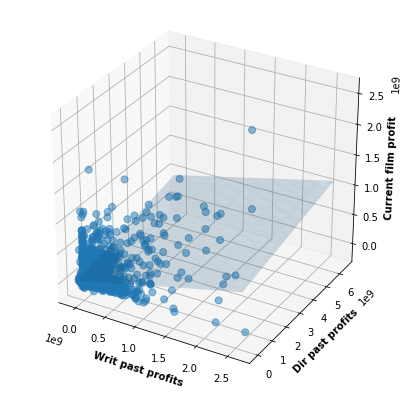

In [32]:
# regular grid covering the domain of the data
# MAKE SURE arange INTERVALS ARE NOT TOO SMALL, TAKES FOREVER TO RUN OTHERWISE
X,Y = np.meshgrid(np.arange(-83372628, 2649903959, 100000000), np.arange(-79627709, 6490889213, 100000000))

# print("IM HERE")

XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
# fig = plt.figure()
# ax = fig.gca(projection='3d')

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# print("IM HERE 2")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
# print("IM HERE 3")
ax.scatter(data[:,0], data[:,1], data[:,2], s=50, alpha=0.5)#, c='r')
ax.set_xlabel('Writ past profits', fontweight='bold')
ax.set_ylabel('Dir past profits', fontweight='bold')
ax.set_zlabel('Current film profit', fontweight='bold')
ax.axis('equal')
ax.axis('tight')
plt.show()

## Make dummy vars for "season" (as discussed above)

## Make dummy vars for genre

## Saving this new iteration of the data to csv

#### Check that data types are ok and make any needed conversions:

## Next step: trying out different models...